# Predict the Number of Passengers for air travel in the next month

### Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
!ls -l 'drive/My Drive/AIML/SequentialModels'

total 659
-rw------- 1 root root   2182 Apr 12 03:41  airline-passengers.csv
-rw------- 1 root root 183904 Apr 12 07:48 'google (1).csv'
-rw------- 1 root root  48240 Apr 12 06:04  Lab0_Word2vec_gensim_movie_data.ipynb
-rw------- 1 root root 215415 May 31 20:02 'Lab1_TimeSeries - Air Passengers Traffic.ipynb'
-rw------- 1 root root 186016 Apr 12 03:41  Lab2_stockPriceDirectionPrediction_v2.ipynb
-rw------- 1 root root   8544 Apr 12 03:41 'LSTM Sentiment Analysis Kaggle.ipynb'
-rw------- 1 root root  20445 Jun  1 05:07  Predict_Air_Passengers_Traffic_TS.ipynb
drwx------ 2 root root   4096 Jun  1 03:23  savedModels
-rw------- 1 root root   1763 Apr 12 07:48  Tractor-Sales.csv
-rw------- 1 root root    915 Apr 12 07:48  wsbSalesData.csv
-rw------- 1 root root    151 May 31 19:28  wsbSalesData.gsheet


In [5]:
df = pd.read_csv('/content/drive/My Drive/AIML/SequentialModels/airline-passengers.csv')
df.sort_index(inplace=True)
df.shape

(144, 2)

In [6]:
df.head(4)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129


In [7]:
df.tail(4)

,Month,Passengers
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


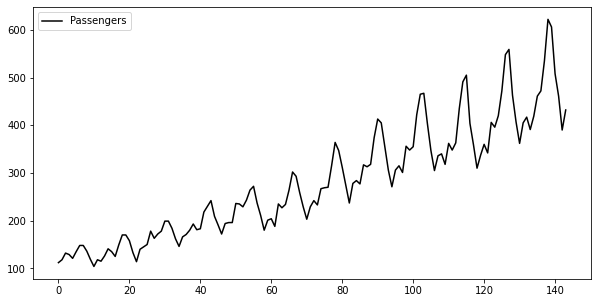

In [8]:
#Plot of complete dataset
ax = df.plot(figsize=(10,5), color ='black')

#### Observations:
- We see a nice snake pattern going up
- There is seasonality in the data.
- There is an upward trend in the data
- The seasonality is expanding.Initially the seasonality curve(s-shape in each season) is small, but as we move from left to right, the seasonality is increasing.
- The variance is increasig as we move from left to right, because the ups and downs are huge in the latter part.

### Data Preprocessing

In [9]:
#Check for null values
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [10]:
#Check Data Range
print('Min', np.min(df))
print('Max', np.max(df))

Min Month         1949-01
Passengers        104
dtype: object
Max Month         1960-12
Passengers        622
dtype: object


In [0]:
#Drop Month columns as it is not used for prediction.The time column is only a primary key
df.drop("Month", axis=1, inplace=True)

In [0]:
#Normalize the data
#Use MinMax Scaler to scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

In [0]:
#we can get original data from scaled data using inverse_transform
#scaled.inverse_transform(scaler)

### Split Data

In [14]:
#70% examples will used for training (in the begining)
train_size = int(len(scaled) * 0.70)

#30% will be used for Test
#test_size = len(scaled - train_size)
test_size = len(scaled) - train_size

print("Train size and Test size are : ",train_size, test_size, len(scaled))

Train size and Test size are :  100 44 144


In [15]:
#Split the data
train = scaled[0:train_size, :]
test = scaled[train_size: len(scaled), :]
print('train Size : {}\ntest Size: {}'.format(len(train), len(test)))
print('train Shape : {}\ntest Shape: {}'.format(train.shape, test.shape))
print('\ntrain :\n {}\n\ntest : {}'.format(train[0:2], test[0:2]))

train Size : 100
test Size: 44
train Shape : (100, 1)
test Shape: (44, 1)

train :
 [[0.01544402]
 [0.02702703]]

test : [[0.48455598]
 [0.61389961]]


### Build Input and Output data
for both Training and Test based on the window or past history size

In [0]:
#window - how long the sequence will be or how many time steps to predict
#function to create X_train, y_train and X_test, y_test
def create_dataset(dataset, window=1):
    
    dataX, dataY = [], []
    
    for i in range(len(dataset)-window):
        #print(i, i+window)

        #X_train
        a = dataset[i:(i+window), 0]

        #y_train
        b = dataset[i+window, 0]

        #print(a, b)
        dataX.append(a)
        dataY.append(b)
    
    return np.array(dataX), np.array(dataY)

In [0]:
#Create Input and Output
window_size =1
X_train, y_train = create_dataset(train, window_size)
X_test, y_test = create_dataset(test, window_size)

In [19]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(99, 1) (99,)
(43, 1) (43,)


In [20]:
X_train[0:5]

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]])

In [21]:
#The second datapoint of X_train, will be first datapoint of y_train
y_train[0:5]

array([0.02702703, 0.05405405, 0.04826255, 0.03281853, 0.05984556])

###Compare multiple classical regression 
#####Classical machine learning Algorithms : LR, KNN, SVR, DT (CART), RF
- Linear regression
- K-nearest neighbors regression
- Support vector machines regression
- Decision trees regression
- Random Forest regression

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [0]:
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVM', SVR()))
models.append(('CART1', DecisionTreeRegressor(max_depth=10)))
models.append(('CART2', DecisionTreeRegressor(max_depth=4)))
models.append(('RF', RandomForestRegressor()))

In [25]:
# Model Performance of each model
# evaluate each model in turn
results = []
names = []
for name, model in models:
    model = model.fit(X_train, y_train)
    msg = "%s: %f (%f) " % (name, model.score(X_train, y_train), model.score(X_test, y_test))
    print("Model name: Train-score(Test-score)")
    print(msg)

Model name: Train-score(Test-score)
LR: 0.900005 (0.580570) 
Model name: Train-score(Test-score)
KNN: 0.903753 (-0.421975) 
Model name: Train-score(Test-score)
SVM: 0.846570 (-2.303297) 
Model name: Train-score(Test-score)
CART1: 0.982429 (-0.066860) 
Model name: Train-score(Test-score)
CART2: 0.929672 (-0.338667) 
Model name: Train-score(Test-score)
RF: 0.964812 (-0.166352) 


#### Observations:
- In this case LR model is an overfit model, with 90% Train R2 and 58%
- All the remaining models are performing very poorly with a negative Test R2, and can be discarded 

In [0]:
## Let us consider Linear regression
#model = LinearRegression()
#model.fit(X_train, y_train)

In [26]:
## Let us consider DecisionTree regression
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
#Predit values on X_train and X_test
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

#Reshape  trainPredict
trainPredict = trainPredict.reshape(-1,1)

#Un-normalize the predited data in trainPredict
trainPredict = scaler.inverse_transform(trainPredict)

#Reshape  testPredict
testPredict = testPredict.reshape(-1,1)

#Un-normalize the predited data in testPredict
testPredict = scaler.inverse_transform(testPredict)

In [28]:
trainPredict.shape

(99, 1)

In [29]:
testPredict.shape

(43, 1)

In [30]:
#shift train predictions for plotting
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict

#shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2):len(scaled), :] = testPredict

print(trainPredictPlot.shape, testPredictPlot.shape)
print(trainPredictPlot[0:3], trainPredictPlot[98:101])
print(testPredictPlot[100:103], testPredictPlot[141:])

(144, 1) (144, 1)
[[  nan]
 [118. ]
 [123.5]] [[356.]
 [348.]
 [ nan]]
[[ nan]
 [306.]
 [405.]] [[405.]
 [405.]
 [355.]]


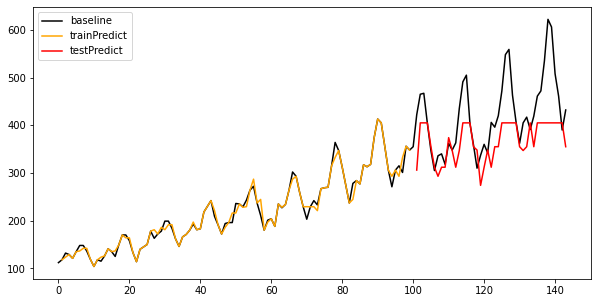

In [31]:
# plot baseline, trainPredict and testPredict
plt.figure(figsize=(10,5))
labels = ['baseline', 'trainPredict', 'testPredict']

#baseline plot
plt.plot(scaler.inverse_transform(scaled), color='black')

#Train Predicted Plot
plt.plot(trainPredictPlot, color='orange')

#Test Predicted Plot
plt.plot(testPredictPlot, color='red')

plt.legend(labels)
plt.show()

### Observations:
- Black plot is original data, orange is trainpredicted and red is testPredicted
- red is far away from black plot.There is a deviation of red from black, but orange is closer to black plot in the beginning
- The trainPredictions are approximately close to baseline predictions, so we can say the model is doing well on train dataset
- The testPredictions are far away from baseline predictions, so we can say the model is not performing well on test dataset
- This is the reason Decision tree is performing very badly on the data and it is clear/evident from this plot
- We can increase this model furthur by using LSTM

#### The LSTM network expects the input data (X) to be provided with a specific array structure in the form of : [samples, time steps, features]

In [32]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(99, 1) (99,)
(43, 1) (43,)


In [33]:
print(X_train.shape[0], X_train.shape[1], 1)
print(X_test.shape[0], X_test.shape[1], 1)

99 1 1
43 1 1


In [34]:
#Make it 3 Dimensional Data - needed for LSTM
#dim1: No of rows
#dim2: No of months into the past which we use to predict the present(past history)
#dim3: No of features
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(99, 1, 1)
(43, 1, 1)


### Build the Model

In [0]:
#Clear the session before adding a model
tf.keras.backend.clear_session()

#Add a Sequential container
model = tf.keras.Sequential()

#Add the LSTM layer with some Memory Units.
#No of Memory Units=32 indicates, the number of floating values in Long Term Memory(LTM) as well as Short Term Memory(STM)
#In current Keras implementation, the number of floating values in LTM = number of floating values in STM
model.add(tf.keras.layers.LSTM(32, input_shape=(window_size, 1)))

#For all Regression and LSTM problems, the final layer is always a dense layer with one output
model.add(tf.keras.layers.Dense(1))

#For compiing the model, use adam as the optimizer and since it is a regression problem, we use mse as the loss function
model.compile(optimizer='adam', loss='mse')

In [0]:
#Add model checkpoint to save the best model weights.The best model is one with least validation loss
LSTMcheckpoint_path = "/content/drive/My Drive/AIML/SequentialModels/savedModels/lstm.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=LSTMcheckpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode = 'min',
                                                 save_best_only=True,
                                                 verbose=1)

In [37]:
#Run the model for 1500 epochs , with batch size of 32, save weights of best model using callbacks
model.fit(X_train, y_train, epochs=1500, validation_data=(X_test, y_test), batch_size=32, callbacks=[cp_callback])

Streaming output truncated to the last 5000 lines.
1/4 [======>.......................] - ETA: 0s - loss: 0.0020
Epoch 00251: val_loss did not improve from 0.00967
4/4 [==============================] - 0s 14ms/step - loss: 0.0021 - val_loss: 0.0099
Epoch 252/1500
1/4 [======>.......................] - ETA: 0s - loss: 0.0024
Epoch 00252: val_loss did not improve from 0.00967
4/4 [==============================] - 0s 16ms/step - loss: 0.0021 - val_loss: 0.0099
Epoch 253/1500
1/4 [======>.......................] - ETA: 0s - loss: 0.0019
Epoch 00253: val_loss did not improve from 0.00967
4/4 [==============================] - 0s 14ms/step - loss: 0.0021 - val_loss: 0.0098
Epoch 254/1500
1/4 [======>.......................] - ETA: 0s - loss: 0.0026
Epoch 00254: val_loss did not improve from 0.00967
4/4 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 0.0098
Epoch 255/1500
1/4 [======>.......................] - ETA: 0s - loss: 0.0020
Epoch 00255: val_loss did not i

### Load saved weights

In [38]:
# Loads the weights
model.load_weights(LSTMcheckpoint_path)

### Model evaluation

In [39]:
#Train loss (trainMSE)
train_loss_and_metrics = model.evaluate(X_train, y_train)
print(train_loss_and_metrics)

#Test loss (testMSE)
test_loss_and_metrics = model.evaluate(X_test, y_test)
print(test_loss_and_metrics)

4/4 [==============================] - 0s 3ms/step - loss: 0.0023
0.0022998563945293427
2/2 [==============================] - 0s 3ms/step - loss: 0.0085
0.008491056971251965


### Model Prediction
### Get Predictions for both Training and Test Data

In [0]:
#Get prediction for both Training and Test Data
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [41]:
print(X_train.shape, y_train.shape, trainPredict.shape)

(99, 1, 1) (99,) (99, 1)


In [42]:
print(X_test.shape, y_test.shape, testPredict.shape)

(43, 1, 1) (43,) (43, 1)


In [43]:
print(X_train[0],y_train[0], trainPredict[0])
print(X_test[0],y_test[0], testPredict[0])

[[0.01544402]] 0.02702702702702703 [0.04332863]
[[0.48455598]] 0.6138996138996139 [0.49350747]


### Model Performance
### Train and Test  R2 and RMSE

In [0]:
from sklearn.metrics import r2_score, mean_squared_error

In [45]:
#Train R2 and Test R2
print("Train R2 (Accuracy) is ",r2_score(y_train, trainPredict))
print("Test R2 (Accuracy) is ",r2_score(y_test, testPredict))

Train R2 (Accuracy) is  0.8855780848562604
Test R2 (Accuracy) is  0.612267564315315


In [46]:
#Train MSE and Test MSE
print("Train mse (loss) is ",mean_squared_error(y_train, trainPredict))
print("Test mse (loss) is ",mean_squared_error(y_test, testPredict))

Train mse (loss) is  0.002299856354175037
Test mse (loss) is  0.00849105699303145


In [47]:
#Train RMSE and Test RMSE
print("Train rmse (loss) is ",np.sqrt(mean_squared_error(y_train, trainPredict)))
print("Test rmse (loss) is ",np.sqrt(mean_squared_error(y_test, testPredict)))

Train rmse (loss) is  0.04795681759849205
Test rmse (loss) is  0.09214693154430836


## Prediction for a new input value

In [48]:
myInput = np.reshape(scaler.transform(pd.DataFrame({"Passengers":[700]})),(1,1,1))
int(scaler.inverse_transform(model.predict(myInput)))

646

- If the number of passengers in current month is 700, then no of passengers in the next month would be 646

In [49]:
myInput = np.reshape(scaler.transform(pd.DataFrame({"Passengers":[730]})),(1,1,1))
int(scaler.inverse_transform(model.predict(myInput)))

668

- If the number of passengers in current month is 730, then no of passengers in the next month would be 668

In [50]:
myInput = np.reshape(scaler.transform(pd.DataFrame({"Passengers":[390, 432]})), (2,1,1))
print(scaler.inverse_transform(model.predict(np.reshape(myInput, (2, 1, 1)))))
np.int32(scaler.inverse_transform(model.predict(np.reshape(myInput, (2, 1, 1)))))

[[391.55423]
 [429.11807]]


array([[391],
       [429]], dtype=int32)

- If the number of passengers in current month is 390, then no of passengers in the next month would be 391 and if number of passengers in current month is 432, then no of passengers in the next month would be 429

In [0]:
#Un-normalize the predited data
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

### Plot to visualize Baseline, Train Predictions and Test Predictions

In [52]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2):len(scaled), :] = testPredict

print(trainPredictPlot.shape, testPredictPlot.shape)
print(trainPredictPlot[0:3], trainPredictPlot[98:101])
print(testPredictPlot[100:103], testPredictPlot[141:])

(144, 1) (144, 1)
[[         nan]
 [126.44422913]
 [132.36642456]] [[309.39538574]
 [360.55618286]
 [         nan]]
[[         nan]
 [359.63687134]
 [420.25024414]] [[494.86871338]
 [454.55612183]
 [391.55422974]]


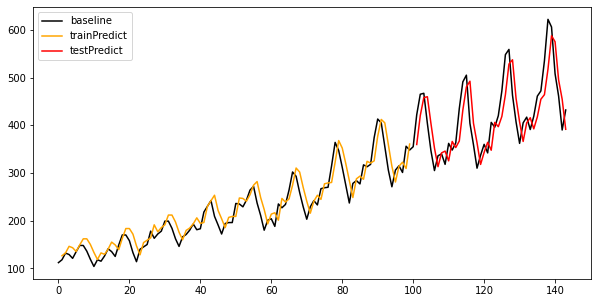

In [53]:
# plot baseline, trainPredict and testPredict
plt.figure(figsize=(10,5))
labels = ['baseline', 'trainPredict', 'testPredict']

#baseline plot
plt.plot(scaler.inverse_transform(scaled), color='black')

#Train Predicted Plot
plt.plot(trainPredictPlot, color='orange')

#Test Predicted Plot
plt.plot(testPredictPlot, color='red')

plt.legend(labels)
plt.show()

#### Observations:
- The plot shows that the model is performing well, both on train data and test data
- The black plot is for complete data, orange for train predicted and red for test predicted
- Both the orange and red plots are close to the black plot
- LSTM is performing quiet well on this timeseries dataset